## Notebook to plot the latent dimensions

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from vae import VAE
from base_VAE import BaseVAE
from tensorflow.keras.models import load_model
from sklearn.manifold import TSNE

### Load data

In [2]:
X_tcga_no_brca = pd.read_pickle("../data/tcga_raw_no_labelled_brca_log_row_normalized.pkl")

X_brca_train = pd.read_pickle("../data/tcga_brca_raw_19036_row_log_norm_train.pkl")

y_brca_train = X_brca_train["Ciriello_subtype"]

X_brca_train.drop(['tcga_id', 'Ciriello_subtype', 'sample_id', 'cancer_type'], axis="columns", inplace=True)

### Set params

In [3]:
hidden_dim = 300
latent_dim = 100
batch_size = 50
epochs = 100
learning_rate = 0.001
dropout_input = 0.6
dropout_hidden = 0.6
dropout_decoder = True
freeze_weights = False
classifier_use_z = False
reconstruction_loss = "binary_crossentropy"

### Scale and split

In [4]:
scaler = MinMaxScaler()
X_autoencoder = X_tcga_no_brca
X_autoencoder_scaled = pd.DataFrame(scaler.fit_transform(X_autoencoder), columns=X_autoencoder.columns)

# Scale training data
X_train = pd.DataFrame(scaler.transform(X_brca_train), columns=X_brca_train.columns)

#Split validation set
validation_set_percent = 0.1
X_autoencoder_val = X_autoencoder_scaled.sample(frac=validation_set_percent)
X_autoencoder_train = X_autoencoder_scaled.drop(X_autoencoder_val.index)


# Order the features correctly before training
X_autoencoder_train = X_autoencoder_train.reindex(sorted(X_autoencoder_train.columns), axis="columns")
X_autoencoder_val = X_autoencoder_val.reindex(sorted(X_autoencoder_val.columns), axis="columns")
X_train = X_train.reindex(sorted(X_train.columns), axis="columns")

### Get raw data embedings

In [5]:
raw_comp = TSNE(n_components=2).fit_transform(X_train)
raw_comp_df = pd.DataFrame(raw_comp, columns = ['principal component 1', 'principal component 2'])
raw_comp_df.head(5)

,principal component 1,principal component 2
0,16.449995,36.377869
1,4.866487,35.710621
2,8.192098,31.456795
3,10.191667,33.990547
4,7.224635,27.799625


Text(0.5, 0.98, 'Raw data')

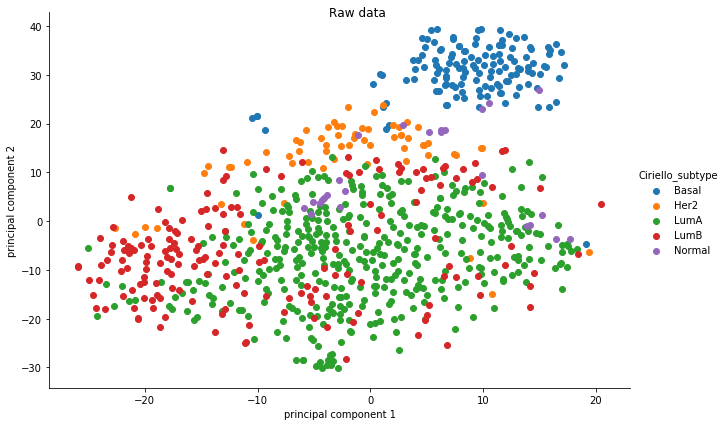

In [6]:
raw_comp_df_subtype = pd.concat([raw_comp_df, y_brca_train], axis=1)
fg = seaborn.FacetGrid(data=raw_comp_df_subtype, hue="Ciriello_subtype", height=6, aspect=1.5)
fg.map(plt.scatter, 'principal component 1', 'principal component 2').add_legend()
fg.fig.suptitle('Raw data')

### Train the VAE on full TCGA data

In [7]:
#Train the Model
vae = VAE(original_dim=X_autoencoder_train.shape[1], 
            intermediate_dim=hidden_dim, 
            latent_dim=latent_dim, 
            epochs=1, 
            batch_size=batch_size, 
            learning_rate=learning_rate, 
            dropout_rate_input=dropout_input,
            dropout_rate_hidden=dropout_hidden,
            freeze_weights=freeze_weights, 
            classifier_use_z=classifier_use_z,
            rec_loss=reconstruction_loss)

vae.initialize_model()
vae.train_vae(train_df=X_autoencoder_train, val_df=X_autoencoder_val)

AUTOENCODER HAS DEPTH 2
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Colocations handled automatically by placer.
Train on 8358 samples, validate on 929 samples
Instructions for updating:
Use tf.cast instead.
8358/8358 [==============================] - 38s 5ms/sample - loss: 10422.6099 - val_loss: 10113.9767


### Get embeddings after training 1 epoch

In [8]:
result = vae.encoder.predict(X_brca_train)
means = pd.DataFrame(result[0])

means_comp = TSNE(n_components=2).fit_transform(means)
means_comp_df = pd.DataFrame(means_comp, columns = ['principal component 1', 'principal component 2'])
means_comp_df.head(5)

,principal component 1,principal component 2
0,24.710587,-19.545456
1,19.653917,-14.475634
2,33.709415,-2.956954
3,30.302641,-7.212362
4,22.536123,14.910563


Text(0.5, 0.98, 'After training 1 epoch')

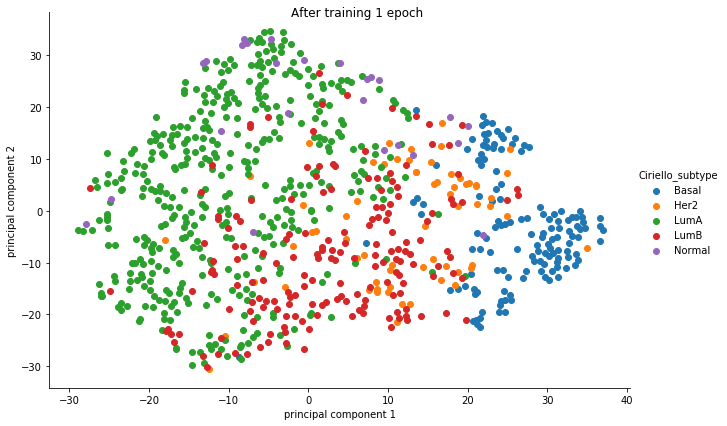

In [9]:
means_comp_df_subtype = pd.concat([means_comp_df, y_brca_train], axis=1)
fg = seaborn.FacetGrid(data=means_comp_df_subtype, hue="Ciriello_subtype", height=6, aspect=1.5)
fg.map(plt.scatter, 'principal component 1', 'principal component 2').add_legend()
fg.fig.suptitle('After training 1 epoch')

### Get embeddings after training 100 epochs

In [10]:
#Train the Model
vae = VAE(original_dim=X_autoencoder_train.shape[1], 
            intermediate_dim=hidden_dim, 
            latent_dim=latent_dim, 
            epochs=epochs, 
            batch_size=batch_size, 
            learning_rate=learning_rate, 
            dropout_rate_input=dropout_input,
            dropout_rate_hidden=dropout_hidden,
            freeze_weights=freeze_weights, 
            classifier_use_z=classifier_use_z,
            rec_loss=reconstruction_loss)

vae.initialize_model()
vae.train_vae(train_df=X_autoencoder_train, val_df=X_autoencoder_val)

AUTOENCODER HAS DEPTH 2
Train on 8358 samples, validate on 929 samples
Epoch 1/100
8358/8358 [==============================] - 28s 3ms/sample - loss: 10424.5586 - val_loss: 10132.4120
Epoch 2/100
8358/8358 [==============================] - 27s 3ms/sample - loss: 10122.1043 - val_loss: 10001.1280
Epoch 3/100
8358/8358 [==============================] - 26s 3ms/sample - loss: 10064.7668 - val_loss: 9960.9688
Epoch 4/100
8358/8358 [==============================] - 26s 3ms/sample - loss: 10036.2184 - val_loss: 9935.6195
Epoch 5/100
8358/8358 [==============================] - 26s 3ms/sample - loss: 10017.7105 - val_loss: 9915.7793
Epoch 6/100
8358/8358 [==============================] - 27s 3ms/sample - loss: 10003.8405 - val_loss: 9907.2701
Epoch 7/100
8358/8358 [==============================] - 27s 3ms/sample - loss: 9997.6973 - val_loss: 9897.6197
Epoch 8/100
8358/8358 [==============================] - 26s 3ms/sample - loss: 9988.4604 - val_loss: 9891.8484
Epoch 9/100
8358/8358 [==

In [11]:
result = vae.encoder.predict(X_brca_train)
means = pd.DataFrame(result[0])
from sklearn.manifold import TSNE

means_comp = TSNE(n_components=2).fit_transform(means)
means_comp_df = pd.DataFrame(means_comp, columns = ['principal component 1', 'principal component 2'])
means_comp_df.head(5)

,principal component 1,principal component 2
0,20.496437,-25.444506
1,-20.865189,-8.086994
2,14.555544,-1.196234
3,6.206810,-23.439577
4,11.141006,34.475418


Text(0.5, 0.98, 'After training 100 epochs')

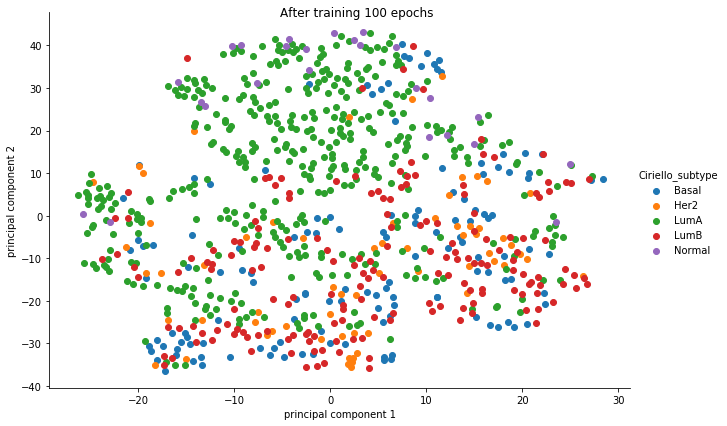

In [12]:
means_comp_df_subtype = pd.concat([means_comp_df, y_brca_train], axis=1)
fg = seaborn.FacetGrid(data=means_comp_df_subtype, hue="Ciriello_subtype", height=6, aspect=1.5)
fg.map(plt.scatter, 'principal component 1', 'principal component 2').add_legend()
fg.fig.suptitle('After training 100 epochs')

### Build stacked classifier

In [13]:
enc = OneHotEncoder(sparse=False)
y_labels_train = enc.fit_transform(y_brca_train.values.reshape(-1, 1))
    
X_train_train, X_train_val, y_labels_train_train, y_labels_train_val = train_test_split(X_brca_train, y_labels_train, test_size=0.2, stratify=y_labels_train, random_state=42)

print("BUILDING CLASSIFIER")
vae.build_classifier()

fit_hist = vae.classifier.fit(x=X_train_train, 
                                y=y_labels_train_train, 
                                shuffle=True, 
                                epochs=100,
                                batch_size=50,
                                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                                validation_data=(X_train_val, y_labels_train_val))

BUILDING CLASSIFIER
Train on 653 samples, validate on 164 samples
Epoch 1/100
653/653 [==============================] - 2s 3ms/sample - loss: 1.4881 - acc: 0.3522 - val_loss: 3.0788 - val_acc: 0.5061
Epoch 2/100
653/653 [==============================] - 1s 1ms/sample - loss: 1.1682 - acc: 0.5743 - val_loss: 2.3565 - val_acc: 0.5061
Epoch 3/100
653/653 [==============================] - 1s 1ms/sample - loss: 0.9943 - acc: 0.6417 - val_loss: 1.9643 - val_acc: 0.5061
Epoch 4/100
653/653 [==============================] - 1s 1ms/sample - loss: 0.9142 - acc: 0.6738 - val_loss: 1.6912 - val_acc: 0.5061
Epoch 5/100
653/653 [==============================] - 1s 1ms/sample - loss: 0.8622 - acc: 0.6815 - val_loss: 1.4680 - val_acc: 0.5122
Epoch 6/100
653/653 [==============================] - 1s 1ms/sample - loss: 0.8099 - acc: 0.7044 - val_loss: 1.3057 - val_acc: 0.5549
Epoch 7/100
653/653 [==============================] - 1s 1ms/sample - loss: 0.7784 - acc: 0.7305 - val_loss: 1.1509 - val_a

### Get embeddings after training the classifier

In [14]:
result = vae.encoder.predict(X_brca_train)
means = pd.DataFrame(result[0])
from sklearn.manifold import TSNE

means_comp = TSNE(n_components=2).fit_transform(means)
means_comp_df = pd.DataFrame(means_comp, columns = ['principal component 1', 'principal component 2'])
means_comp_df.head(5)

,principal component 1,principal component 2
0,-50.695770,-16.758713
1,-41.968922,-21.249630
2,-35.078373,-17.809530
3,-40.616920,-18.581614
4,-37.004360,-11.711321


Text(0.5, 0.98, 'After training classifier')

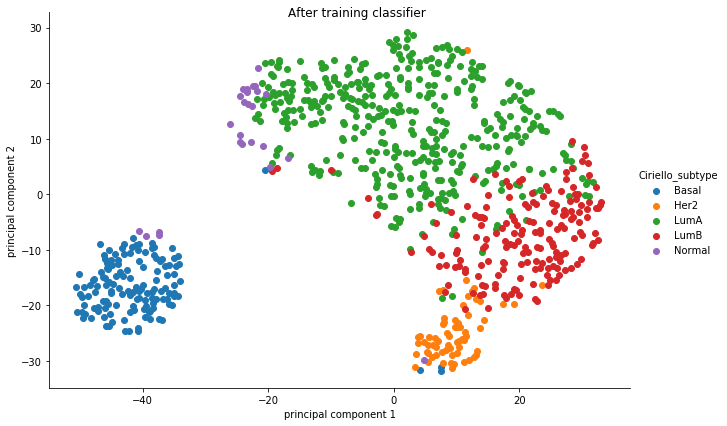

In [15]:
means_comp_df_subtype = pd.concat([means_comp_df, y_brca_train], axis=1)
fg = seaborn.FacetGrid(data=means_comp_df_subtype, hue="Ciriello_subtype", height=6, aspect=1.5)
fg.map(plt.scatter, 'principal component 1', 'principal component 2').add_legend()
fg.fig.suptitle('After training classifier')

# Train VAE on ARCHS4 BRCA subset

### Load data

In [16]:
X_archs4_brca = pd.read_pickle("../data/archs4_brca_tissue_cell_row_log_normalized.pkl")
X_brca_train = pd.read_pickle("../data/tcga_brca_raw_19036_row_log_norm_train.pkl")
y_brca_train = X_brca_train["Ciriello_subtype"]
X_brca_train.drop(['tcga_id', 'Ciriello_subtype', 'sample_id', 'cancer_type'], axis="columns", inplace=True)

### Set params

In [17]:
hidden_dim = 300
latent_dim = 100
batch_size = 50
epochs = 100
learning_rate = 0.001
dropout_input = 0.8
dropout_hidden = 0.4
dropout_decoder = True
freeze_weights = False
classifier_use_z = False
reconstruction_loss = "binary_crossentropy"

### Scale and split

In [18]:
scaler = MinMaxScaler()
X_autoencoder = X_archs4_brca
X_autoencoder_scaled = pd.DataFrame(scaler.fit_transform(X_autoencoder), columns=X_autoencoder.columns)

# Scale training data
X_train = pd.DataFrame(scaler.transform(X_brca_train), columns=X_brca_train.columns)

#Split validation set
validation_set_percent = 0.1
X_autoencoder_val = X_autoencoder_scaled.sample(frac=validation_set_percent)
X_autoencoder_train = X_autoencoder_scaled.drop(X_autoencoder_val.index)


# Order the features correctly before training
X_autoencoder_train = X_autoencoder_train.reindex(sorted(X_autoencoder_train.columns), axis="columns")
X_autoencoder_val = X_autoencoder_val.reindex(sorted(X_autoencoder_val.columns), axis="columns")
X_train = X_train.reindex(sorted(X_train.columns), axis="columns")

### Train the model

In [19]:
#Train the Model
vae = VAE(original_dim=X_autoencoder_train.shape[1], 
            intermediate_dim=hidden_dim, 
            latent_dim=latent_dim, 
            epochs=1, 
            batch_size=batch_size, 
            learning_rate=learning_rate, 
            dropout_rate_input=dropout_input,
            dropout_rate_hidden=dropout_hidden,
            freeze_weights=freeze_weights, 
            classifier_use_z=classifier_use_z,
            rec_loss=reconstruction_loss)

vae.initialize_model()
vae.train_vae(train_df=X_autoencoder_train, val_df=X_autoencoder_val)

AUTOENCODER HAS DEPTH 2
Train on 3711 samples, validate on 412 samples
3711/3711 [==============================] - 12s 3ms/sample - loss: 9380.2261 - val_loss: 9244.9697


### Plot the embedding with 1 epoch of training

In [20]:
result = vae.encoder.predict(X_brca_train)
means = pd.DataFrame(result[0])
from sklearn.manifold import TSNE

means_comp = TSNE(n_components=2).fit_transform(means)
means_comp_df = pd.DataFrame(means_comp, columns = ['principal component 1', 'principal component 2'])
means_comp_df.head(5)

,principal component 1,principal component 2
0,12.262179,1.254243
1,-19.058252,19.172760
2,-13.264467,27.493696
3,-12.977608,29.054531
4,-34.793068,26.105663


Text(0.5, 0.98, 'After training 1 epoch with ARCHS4 BRCA')

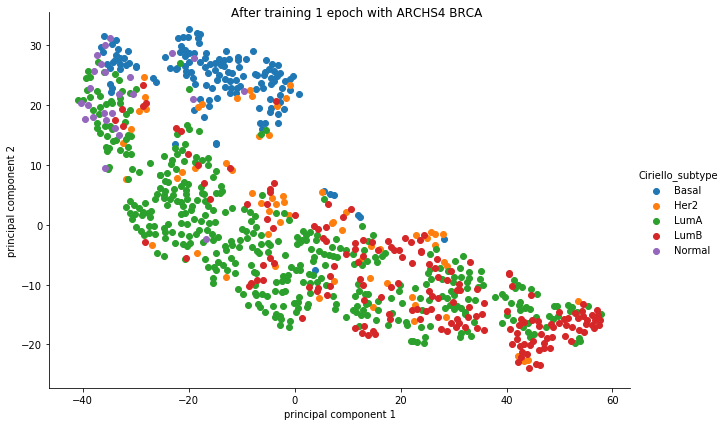

In [21]:
means_comp_df_subtype = pd.concat([means_comp_df, y_brca_train], axis=1)
fg = seaborn.FacetGrid(data=means_comp_df_subtype, hue="Ciriello_subtype", height=6, aspect=1.5)
fg.map(plt.scatter, 'principal component 1', 'principal component 2').add_legend()
fg.fig.suptitle('After training 1 epoch with ARCHS4 BRCA')

### Train it properly

In [22]:
#Train the Model
vae = VAE(original_dim=X_autoencoder_train.shape[1], 
            intermediate_dim=hidden_dim, 
            latent_dim=latent_dim, 
            epochs=epochs, 
            batch_size=batch_size, 
            learning_rate=learning_rate, 
            dropout_rate_input=dropout_input,
            dropout_rate_hidden=dropout_hidden,
            freeze_weights=freeze_weights, 
            classifier_use_z=classifier_use_z,
            rec_loss=reconstruction_loss)

vae.initialize_model()
vae.train_vae(train_df=X_autoencoder_train, val_df=X_autoencoder_val)

AUTOENCODER HAS DEPTH 2
Train on 3711 samples, validate on 412 samples
Epoch 1/100
3711/3711 [==============================] - 14s 4ms/sample - loss: 9394.9028 - val_loss: 8875.8255
Epoch 2/100
3711/3711 [==============================] - 12s 3ms/sample - loss: 8781.0341 - val_loss: 8682.7750
Epoch 3/100
3711/3711 [==============================] - 11s 3ms/sample - loss: 8703.1423 - val_loss: 8603.7265
Epoch 4/100
3711/3711 [==============================] - 11s 3ms/sample - loss: 8651.6159 - val_loss: 8533.9685
Epoch 5/100
3711/3711 [==============================] - 12s 3ms/sample - loss: 8608.9359 - val_loss: 8512.3788
Epoch 6/100
3711/3711 [==============================] - 11s 3ms/sample - loss: 8578.0507 - val_loss: 8495.5270
Epoch 7/100
3711/3711 [==============================] - 12s 3ms/sample - loss: 8565.1767 - val_loss: 8465.8060
Epoch 8/100
3711/3711 [==============================] - 11s 3ms/sample - loss: 8556.8013 - val_loss: 8477.0948
Epoch 9/100
3711/3711 [==========

### Plot the embedding after 100 epochs of training

In [23]:
result = vae.encoder.predict(X_brca_train)
means = pd.DataFrame(result[0])
from sklearn.manifold import TSNE

means_comp = TSNE(n_components=2).fit_transform(means)
means_comp_df = pd.DataFrame(means_comp, columns = ['principal component 1', 'principal component 2'])
means_comp_df.head(5)

,principal component 1,principal component 2
0,-4.768436,-43.411949
1,6.320687,-28.307459
2,0.532674,-31.026175
3,-1.415034,-33.608074
4,12.399623,-23.524464


Text(0.5, 0.98, 'After training 100 epochs with ARCHS4 BRCA')

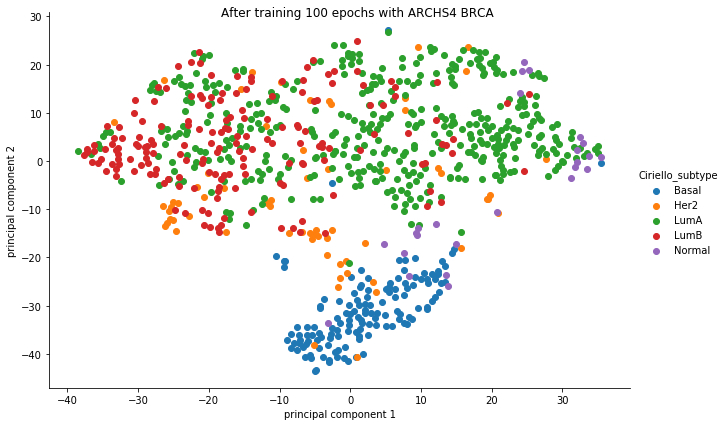

In [24]:
means_comp_df_subtype = pd.concat([means_comp_df, y_brca_train], axis=1)
fg = seaborn.FacetGrid(data=means_comp_df_subtype, hue="Ciriello_subtype", height=6, aspect=1.5)
fg.map(plt.scatter, 'principal component 1', 'principal component 2').add_legend()
fg.fig.suptitle('After training 100 epochs with ARCHS4 BRCA')

### Build and train stacked classifier

In [25]:
enc = OneHotEncoder(sparse=False)
y_labels_train = enc.fit_transform(y_brca_train.values.reshape(-1, 1))
    
X_train_train, X_train_val, y_labels_train_train, y_labels_train_val = train_test_split(X_brca_train, y_labels_train, test_size=0.2, stratify=y_labels_train, random_state=42)

print("BUILDING CLASSIFIER")
vae.build_classifier()

fit_hist = vae.classifier.fit(x=X_train_train, 
                                y=y_labels_train_train, 
                                shuffle=True, 
                                epochs=100,
                                batch_size=50,
                                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)],
                                validation_data=(X_train_val, y_labels_train_val))

BUILDING CLASSIFIER
Train on 653 samples, validate on 164 samples
Epoch 1/100
653/653 [==============================] - 2s 3ms/sample - loss: 1.6323 - acc: 0.3522 - val_loss: 8.0425 - val_acc: 0.0244
Epoch 2/100
653/653 [==============================] - 1s 1ms/sample - loss: 1.1933 - acc: 0.5681 - val_loss: 6.4217 - val_acc: 0.5061
Epoch 3/100
653/653 [==============================] - 1s 1ms/sample - loss: 0.9752 - acc: 0.6616 - val_loss: 5.6307 - val_acc: 0.5061
Epoch 4/100
653/653 [==============================] - 1s 1ms/sample - loss: 0.8762 - acc: 0.7044 - val_loss: 4.7196 - val_acc: 0.5061
Epoch 5/100
653/653 [==============================] - 1s 1ms/sample - loss: 0.7857 - acc: 0.7213 - val_loss: 3.8847 - val_acc: 0.5061
Epoch 6/100
653/653 [==============================] - 1s 1ms/sample - loss: 0.7358 - acc: 0.7060 - val_loss: 3.1190 - val_acc: 0.5061
Epoch 7/100
653/653 [==============================] - 1s 1ms/sample - loss: 0.6987 - acc: 0.7259 - val_loss: 2.4871 - val_a

In [26]:
result = vae.encoder.predict(X_brca_train)
means = pd.DataFrame(result[0])
from sklearn.manifold import TSNE

means_comp = TSNE(n_components=2).fit_transform(means)
means_comp_df = pd.DataFrame(means_comp, columns = ['principal component 1', 'principal component 2'])
means_comp_df.head(5)

,principal component 1,principal component 2
0,-51.409359,-18.595249
1,-42.552650,-13.428797
2,-51.262074,-11.718336
3,-50.264751,-13.968704
4,-44.538990,-2.509878


Text(0.5, 0.98, 'After training classifier')

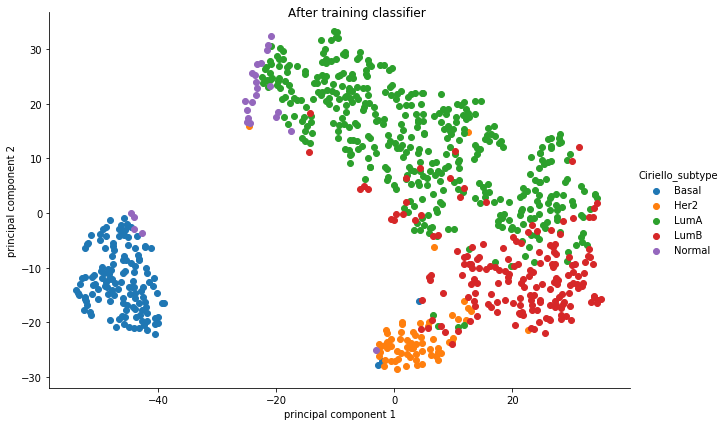

In [27]:
means_comp_df_subtype = pd.concat([means_comp_df, y_brca_train], axis=1)
fg = seaborn.FacetGrid(data=means_comp_df_subtype, hue="Ciriello_subtype", height=6, aspect=1.5)
fg.map(plt.scatter, 'principal component 1', 'principal component 2').add_legend()
fg.fig.suptitle('After training classifier')

<br>
<br>


# Let's check the embedding after training the VAE with the full ARCHS4 dataset

In [28]:
vae = VAE(original_dim=X_autoencoder_train.shape[1], 
            intermediate_dim=hidden_dim, 
            latent_dim=latent_dim, 
            epochs=epochs, 
            batch_size=batch_size, 
            learning_rate=learning_rate, 
            dropout_rate_input=dropout_input,
            dropout_rate_hidden=dropout_hidden,
            freeze_weights=freeze_weights, 
            classifier_use_z=classifier_use_z,
            rec_loss=reconstruction_loss)

vae.initialize_model()

vae.vae.load_weights('../models/vae_300in_100lat_0.6drop_in_0.6drop_hidden_0.001lr_100epochs_full_archs4_weights.h5')

AUTOENCODER HAS DEPTH 2


OSError: Unable to open file (unable to open file: name = '../models/vae_300in_100lat_0.6drop_in_0.6drop_hidden_0.001lr_100epochs_full_archs4_weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
result = vae.encoder.predict(X_brca_train)
means = pd.DataFrame(result[0])
from sklearn.manifold import TSNE

means_comp = TSNE(n_components=2).fit_transform(means)
means_comp_df = pd.DataFrame(means_comp, columns = ['principal component 1', 'principal component 2'])
means_comp_df.head(5)

In [ ]:
means_comp_df_subtype = pd.concat([means_comp_df, y_brca_train], axis=1)
fg = seaborn.FacetGrid(data=means_comp_df_subtype, hue="Ciriello_subtype", height=6, aspect=1.5)
fg.map(plt.scatter, 'principal component 1', 'principal component 2').add_legend()
fg.fig.suptitle('After training 100 epochs full ARCHS4 - 100k samples')